In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
santa = pd.read_csv("C:/Users/katam/OneDrive/Documents/machine learning/Project I/santa.csv")

In [3]:
# making copy for manipulation
df = santa.copy()

In [4]:
df.head

<bound method NDFrame.head of        beachid  sex  Agenew  areacat  worry  X6race  tourist       ses  Fever  \
0            2    1     NaN        2      0       2        0  99999.99      0   
1            2    1     5.0        0      1       0        0  42309.00      0   
2            0    1     5.0        0      3       2        0  30907.00      0   
3            0    1     5.0        0      0       2        0  20263.00      0   
4            0    0     5.0        0      0       0        0  33489.00      0   
...        ...  ...     ...      ...    ...     ...      ...       ...    ...   
11681        1    0     8.0        3      2       2        0  22121.00      0   
11682        1    0     8.0        3      2       2        0  22121.00      0   
11683        2    0     8.0        3      2       2        0  22121.00      0   
11684        1    0     8.0        3      3       0        0  47641.00      0   
11685        1    0     8.0        3      0       0        0  47641.00      0  

In [5]:
# Data Overview
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11686 entries, 0 to 11685
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beachid   11686 non-null  int64  
 1   sex       11686 non-null  int64  
 2   Agenew    11685 non-null  float64
 3   areacat   11686 non-null  int64  
 4   worry     11686 non-null  int64  
 5   X6race    11686 non-null  int64  
 6   tourist   11686 non-null  int64  
 7   ses       11686 non-null  float64
 8   Fever     11686 non-null  int64  
 9   Chills    11686 non-null  int64  
 10  Eyedisc   11686 non-null  int64  
 11  Earache   11686 non-null  int64  
 12  Eardisc   11686 non-null  int64  
 13  Skinrash  11686 non-null  int64  
 14  Infectn   11686 non-null  int64  
 15  Nausea    11686 non-null  int64  
 16  Vomiting  11686 non-null  int64  
 17  Diarrhea  11686 non-null  int64  
 18  Diwbld    11686 non-null  int64  
 19  Stompain  11686 non-null  int64  
 20  Cough     11686 non-null  in

,beachid,sex,Agenew,areacat,worry,X6race,tourist,ses,Fever,Chills,...,Runnose,Sorethrt,HCGI1,HCGI2,SigResD,QG,X28fecal,ecoli,enter,totalc
count,11686.000000,11686.000000,11685.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,...,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000,11686.000000
mean,0.650779,0.549632,6.847754,1.268869,1.474671,1.158480,0.113726,50791.638058,0.048177,0.025329,...,0.091477,0.068201,0.030293,0.008643,0.049974,5.444493,11188.683958,11328.630919,10972.311204,15604.119351
std,0.731341,0.497552,1.272391,0.925612,1.215293,1.096089,0.317492,25530.000333,0.214150,0.157130,...,0.288299,0.252102,0.171399,0.092568,0.217901,1.709658,31120.005431,31485.356219,31184.786741,40328.687487
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,13472.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,33345.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.430000,18.750000,7.000000,6.000000,80.000000
50%,0.000000,1.000000,7.000000,1.000000,2.000000,2.000000,0.000000,42971.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.170000,66.250000,30.750000,20.000000,380.000000
75%,1.000000,1.000000,8.000000,2.000000,3.000000,2.000000,0.000000,57544.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.030000,391.500000,155.000000,60.000000,4090.000000
max,2.000000,1.000000,8.000000,3.000000,3.000000,3.000000,1.000000,137551.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,17.610000,99999.990000,99999.990000,99999.990000,460000.000000


In [6]:
# Replace missing values (99999.99 is code for missing in this dataset)
df.replace(99999.99, np.nan, inplace=True)

In [7]:
# Checking for missing values
df.isnull().sum()

beachid        0
sex            0
Agenew         1
areacat        0
worry          0
X6race         0
tourist        0
ses         1566
Fever          0
Chills         0
Eyedisc        0
Earache        0
Eardisc        0
Skinrash       0
Infectn        0
Nausea         0
Vomiting       0
Diarrhea       0
Diwbld         0
Stompain       0
Cough          0
Cghphlm        0
Runnose        0
Sorethrt       0
HCGI1          0
HCGI2          0
SigResD        0
QG             0
X28fecal    1277
ecoli       1308
enter       1277
totalc      1277
dtype: int64

In [7]:
# It can be seen that ses(socio-economic status) and bacterial exposure values have missing variables
# I am going to drop the the rows that contain missing values
df = df.dropna(subset=['ses', 'X28fecal', 'ecoli', 'enter', 'totalc'])
print(df.shape)

(8944, 32)


In [8]:
num_vars = ['areacat', 'QG', 'X28fecal', 'ecoli', 'enter', 'totalc']
df[num_vars].describe()

,areacat,QG,X28fecal,ecoli,enter,totalc
count,11686.000000,11686.000000,10409.000000,10378.000000,10409.000000,10409.000000
mean,1.268869,5.444493,293.109184,152.861245,50.191325,5250.240321
std,0.925612,1.709658,900.138579,553.596428,203.063398,29065.982824
min,0.000000,0.710000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.430000,15.500000,6.250000,5.000000,64.000000
50%,1.000000,5.170000,51.250000,21.500000,17.250000,259.750000
75%,2.000000,6.030000,170.000000,72.500000,37.500000,1225.000000
max,3.000000,17.610000,25502.750000,9700.000000,5625.500000,460000.000000


#### Log Transform Bacterial Exposure Values

In [9]:
# Apply log1p transformation (log(x + 1)) to safely handle zeros
bacteria = ['X28fecal', 'ecoli', 'enter', 'totalc']

for var in bacteria:
    df[f'{var}_log'] = np.log10(df[var] + 1)

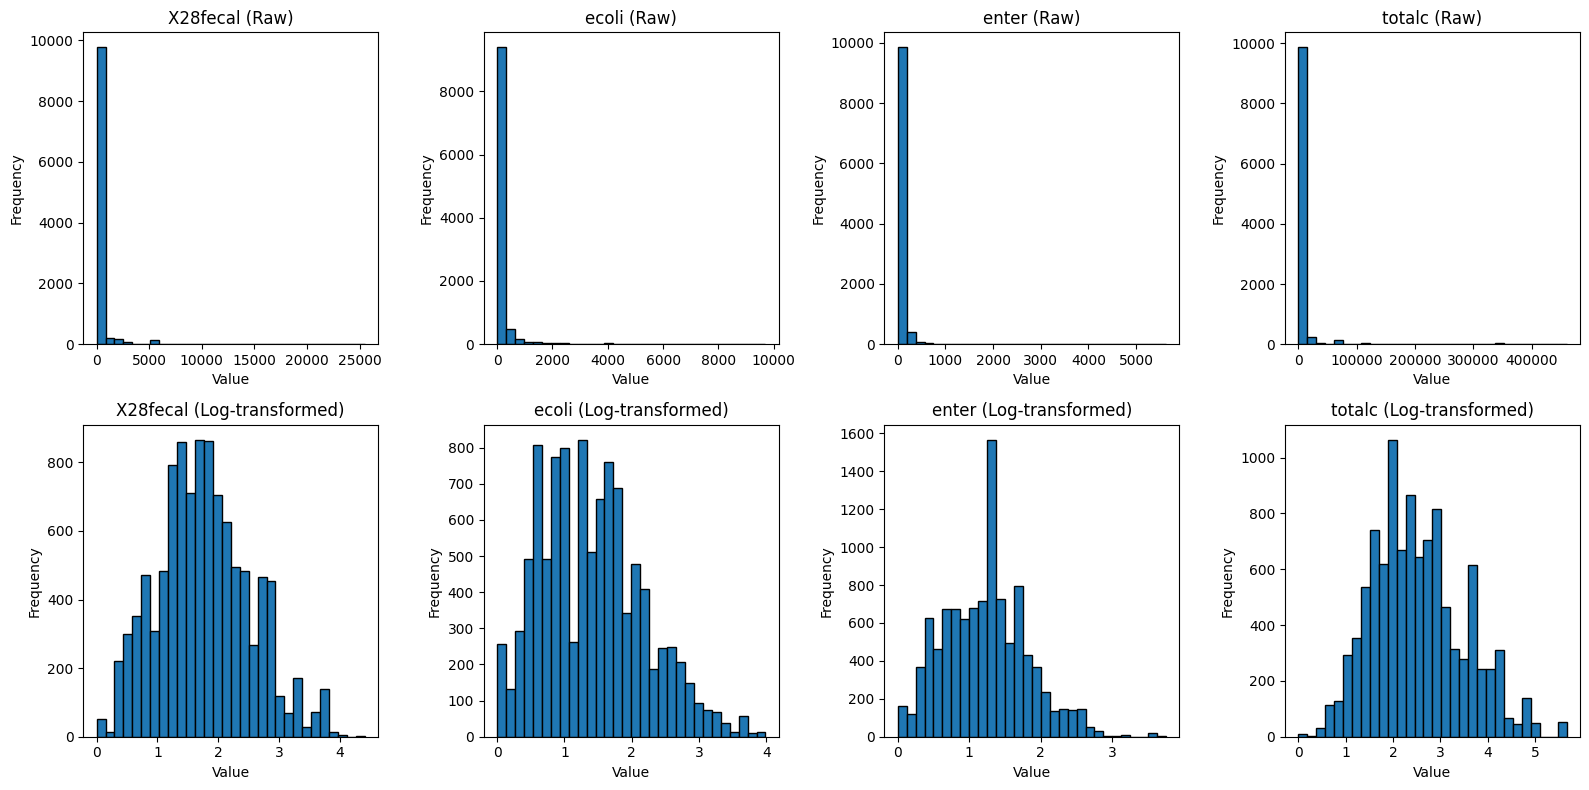

In [10]:
#  (4 indicators × before/after)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, var in enumerate(bacteria):
    # Original (top row)
    axes[0, i].hist(df[var].dropna(), bins=30, edgecolor='black')
    axes[0, i].set_title(f'{var} (Raw)')
    
    # Log-transformed (bottom row)
    axes[1, i].hist(df[f'{var}_log'].dropna(), bins=30, edgecolor='black')
    axes[1, i].set_title(f'{var} (Log-transformed)')

# Formatting
for ax in axes.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The microbial indicator variables were highly right-skewed.
I applied a log(x + 1) transformation, which normalized their distributions and improved linearity for regression analyses.

The microbial indicator variables (fecal coliform, E. coli, enterococcus, and total coliform) exhibited substantial right-skewness in their raw form, which is common for environmental bacterial count data. To reduce skewness and improve normality, a base-10 logarithmic transformation was applied to each variable using the formula log₁₀(x + 1). This transformation compresses the long right tail while preserving relative differences between observations. Histograms before and after transformation indicated a marked improvement toward normal distributions, supporting the use of the log-transformed values in subsequent regression and classification analyses.
On a scientific scale, the log₁₀ transformation facilitates interpretation of microbial exposure effects in multiplicative terms — for example, a one-unit increase on the log scale reflects a tenfold increase in bacterial concentration. This makes it possible to evaluate how large changes in microbial contamination levels correspond to changes in the quantitative gastrointestinal (QG) severity score.

Before log transformation, the microbial indicators (X28fecal, ecoli, enter, totalc) were highly right-skewed — meaning most observations had low bacterial counts, but a few samples had extremely high counts.
Such skewness can distort regression relationships, inflate model error, and violate the assumption of normality.

After applying the base-10 log transformation (log10(x + 1)):
- The distributions became more symmetric and closer to normal.
- Variance was stabilized, reducing the influence of extreme outliers.
- Relationships with other variables (like your quantitative outcome QG) will now be more linear and interpretable in a regression context.



In [11]:
# Create a DataFrame to store skewness values
skew_results = pd.DataFrame(columns=['Raw_Skew', 'Log_Skew'])

for var in bacteria:
    raw_skew = skew(df[var].dropna())
    log_skew = skew(df[f'{var}_log'].dropna())
    skew_results.loc[var] = [raw_skew, log_skew]


print(skew_results)

           Raw_Skew  Log_Skew
X28fecal   9.266779  0.275399
ecoli      8.341478  0.461518
enter     16.999255  0.365430
totalc    11.651762  0.451678


 after transformation:
- The data better reflect the relative differences in contamination levels (rather than being dominated by rare, extreme high counts).
- Relationships between microbial exposure and health outcomes (like QG) can now be modeled more accurately.


In [13]:
# Round skewness values for neatness
skew_styled = (
    skew_results
    .round(3)
    .style
    .set_caption("Table X. Skewness of Microbial Indicators Before and After Log₁₀(x + 1) Transformation")
    .background_gradient(subset=['Raw_Skew'], cmap='Reds', vmin=0, vmax=20)
    .background_gradient(subset=['Log_Skew'], cmap='Greens', vmin=0, vmax=2)
    .format({'Raw_Skew': '{:.3f}', 'Log_Skew': '{:.3f}'})
)
skew_styled

,Raw_Skew,Log_Skew
X28fecal,9.267,0.275
ecoli,8.341,0.462
enter,16.999,0.365
totalc,11.652,0.452


#### **Table X.** Skewness of microbial indicator variables before and after log₁₀(x + 1) transformation. Log transformation substantially reduced skewness across all indicators, improving distributional normality.

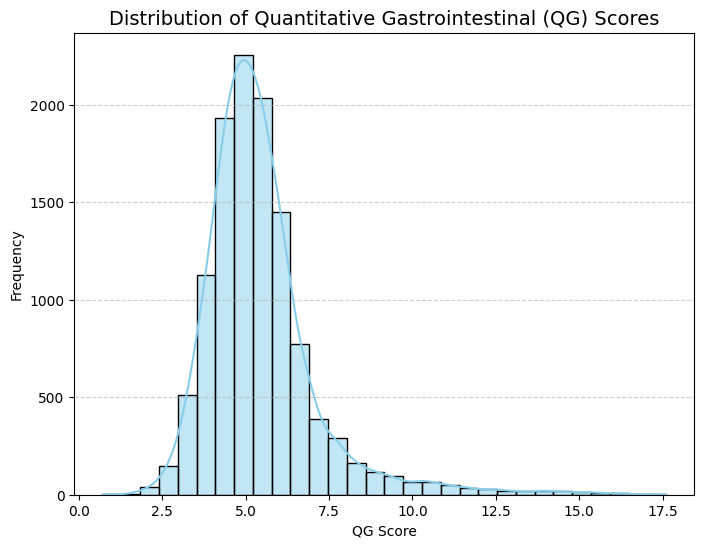

In [11]:
# examine distribution of QG variable
plt.figure(figsize=(8,6))
sns.histplot(df['QG'], kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Quantitative Gastrointestinal (QG) Scores", fontsize=14)
plt.xlabel("QG Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### The Quantitative gastrointestinal (QG) scores ranged from 0 to 17.61, with the majority of participants exhibiting low to moderate values. The distribution is right-skewed, indicating that severe gastrointestinal disease cases were relatively uncommon in the sample. The kernel density estimate (KDE) overlay illustrates the general shape of the distribution and confirms that QG can be treated as a continuous variable for regression modeling.

In [12]:
qg_skew = skew(df['QG'].dropna())
print(f"Skewness of QG: {qg_skew:.3f}")

Skewness of QG: 2.104


QG variable highly right skewed 
- most people have low QG scores (mild or no symptoms) but a few have moderate scored (symptomatic)

- I am going to try some transformations to make the QG distribution more symmetric.

In [13]:
# log transformation
df['QG_log'] = np.log10(df['QG'] + 1)

# square root transformation
df['QG_sqrt'] = np.sqrt(df['QG'])

print("Raw QG skew:", skew(df['QG'].dropna()))
print("Log QG skew:", skew(df['QG_log'].dropna()))
print("Sqrt QG skew:", skew(df['QG_sqrt'].dropna()))


Raw QG skew: 2.1042497742800803
Log QG skew: 0.6944868685866875
Sqrt QG skew: 1.245378793817541


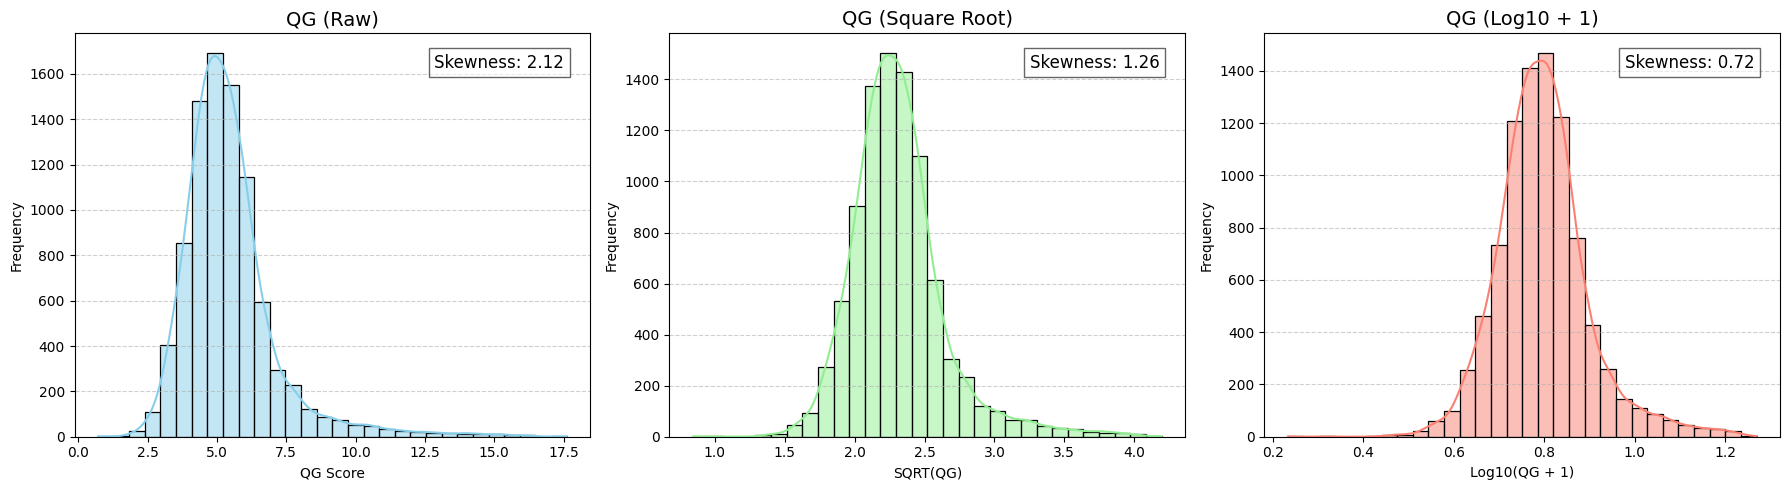

In [17]:
# Compute skewness
skew_raw = skew(df['QG'].dropna())
skew_sqrt = skew(df['QG_sqrt'].dropna())
skew_log = skew(df['QG_log'].dropna())

# Set figure size
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Raw QG
sns.histplot(df['QG'], kde=True, bins=30, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('QG (Raw)', fontsize=14)
axes[0].set_xlabel('QG Score')
axes[0].set_ylabel('Frequency')
axes[0].text(0.95, 0.95, f'Skewness: {skew_raw:.2f}', transform=axes[0].transAxes,
             ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Square root transformed QG
sns.histplot(df['QG_sqrt'], kde=True, bins=30, color='lightgreen', edgecolor='black', ax=axes[1])
axes[1].set_title('QG (Square Root)', fontsize=14)
axes[1].set_xlabel('SQRT(QG)')
axes[1].set_ylabel('Frequency')
axes[1].text(0.95, 0.95, f'Skewness: {skew_sqrt:.2f}', transform=axes[1].transAxes,
             ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Log-transformed QG
sns.histplot(df['QG_log'], kde=True, bins=30, color='salmon', edgecolor='black', ax=axes[2])
axes[2].set_title('QG (Log10 + 1)', fontsize=14)
axes[2].set_xlabel('Log10(QG + 1)')
axes[2].set_ylabel('Frequency')
axes[2].text(0.95, 0.95, f'Skewness: {skew_log:.2f}', transform=axes[2].transAxes,
             ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Add grids
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

##### **Figure X.** Comparison of the distribution of QG scores before and after transformations. Raw QG scores (left) are highly right-skewed (skewness = 2.12). The square root transformation (middle) reduces skewness moderately (1.26), while the log₁₀(x + 1) transformation (right) produces an approximately symmetric distribution (0.72). Kernel density estimates (KDE) are overlaid to illustrate distribution shapes.

#### Results
- The raw QG score (2.12) is clearly non-normal, with a heavy right tail — meaning most participants had mild disease while a few had severe cases.
- The square root transformation helped a little, but the distribution is still somewhat skewed (1.26).
- The log-transformed QG (log₁₀(QG + 1)) reduced skewness to 0.72, which is within acceptable limits (typically |skew| < 1).

#### Conclusion
- The log-transformed QG is the best candidate for downstream analyses such as linear regression or parametric correlations, because it
- Improves normality, Stabilizes variance, Preserves the interpretability of relative changes in disease severity.

#### Report:
The distribution of the quantitative gastrointestinal (QG) severity score was initially right-skewed (skewness = 2.12), indicating that most participants had low disease severity while a few experienced more severe illness. To improve normality, both square root and log₁₀(x + 1) transformations were applied. The square root transformation moderately reduced skewness to 1.26, whereas the log transformation yielded a skewness of 0.72, indicating approximate symmetry. The log-transformed QG variable was therefore used in subsequent analyses to better meet model assumptions.

#### Pearson vs Spearman Correlation for log-transformed microbial indicators 

Pearson Correlation Matrix (Numeric Variables):
              X28fecal_log  ecoli_log  enter_log  totalc_log
X28fecal_log         1.000      0.772      0.738       0.714
ecoli_log            0.772      1.000      0.775       0.590
enter_log            0.738      0.775      1.000       0.560
totalc_log           0.714      0.590      0.560       1.000

Spearman Correlation Matrix:
              X28fecal_log  ecoli_log  enter_log  totalc_log
X28fecal_log         1.000      0.793      0.757       0.691
ecoli_log            0.793      1.000      0.786       0.593
enter_log            0.757      0.786      1.000       0.611
totalc_log           0.691      0.593      0.611       1.000


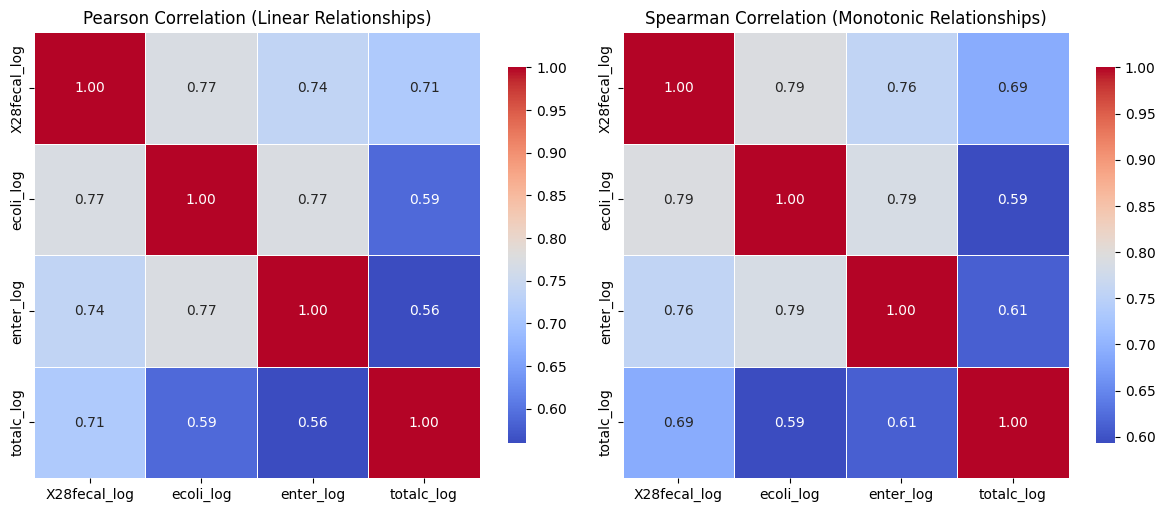

In [15]:
num_vars = ['X28fecal_log', 'ecoli_log', 'enter_log', 'totalc_log']

#  Compute Pearson correlation matrix
pearson_corr = df[num_vars].corr(method='pearson')
spearman_corr = df[num_vars].corr(method='spearman')

# Display numeric results
print("Pearson Correlation Matrix (Numeric Variables):")
print(pearson_corr.round(3))
print("\nSpearman Correlation Matrix:")
print(spearman_corr.round(3))

#  Visualization: Side-by-side heatmaps 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pearson
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.5, square=True, cbar_kws={"shrink": .8}, ax=axes[0])
axes[0].set_title("Pearson Correlation (Linear Relationships)")

# Spearman
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.5, square=True, cbar_kws={"shrink": .8}, ax=axes[1])
axes[1].set_title("Spearman Correlation (Monotonic Relationships)")

plt.tight_layout()
plt.show()

The Pearson correlation coefficients among the log-transformed microbial indicators ranged from 0.56 to 0.77, suggesting moderate to strong positive linear relationships between the different bacterial measures. This means that when the concentration of one bacterial indicator increases, the others tend to increase as well.

The Spearman correlation coefficients ranged from 0.60 to 0.78, showing a similar but slightly higher degree of association. Since Spearman correlation captures monotonic (rank-based) relationships, the similarity in both sets of results indicates that the associations among these indicators are largely linear and consistent across their distributions.

These findings are biologically and environmentally plausible — the bacterial indicators (fecal coliforms, E. coli, enterococcus, and total coliforms) often originate from similar sources of contamination, such as runoff or storm drains, leading to correlated concentrations in water samples.

#### Spearman Correlation for Binary and Categorical Variables

Spearman Correlation Matrix (Categorical/Binary Variables):


,sex,Agenew,areacat,X6race,Fever,Chills,Eyedisc,Earache,Eardisc,Skinrash,...,Diarrhea,Diwbld,Stompain,Cough,Cghphlm,Runnose,Sorethrt,HCGI1,HCGI2,SigResD
sex,1.000,-0.045,0.003,-0.026,-0.003,-0.007,-0.016,-0.008,-0.010,-0.012,...,-0.002,-0.003,-0.014,0.000,0.017,0.004,-0.016,-0.006,0.012,-0.001
Agenew,-0.045,1.000,0.003,0.063,0.037,-0.008,0.016,-0.005,-0.017,-0.002,...,-0.009,0.002,0.016,0.039,0.011,-0.005,-0.021,0.048,0.049,0.022
areacat,0.003,0.003,1.000,0.081,0.014,0.010,-0.006,-0.008,0.009,0.009,...,-0.027,-0.010,-0.004,-0.010,0.013,-0.015,0.006,-0.005,0.007,0.012
X6race,-0.026,0.063,0.081,1.000,-0.002,-0.017,0.027,-0.030,0.004,0.023,...,-0.053,0.006,-0.034,-0.010,-0.003,-0.054,-0.040,-0.004,0.004,-0.008
Fever,-0.003,0.037,0.014,-0.002,1.000,0.597,0.119,0.149,0.080,0.036,...,0.207,0.062,0.235,0.271,0.225,0.246,0.269,0.548,0.415,0.530
Chills,-0.007,-0.008,0.010,-0.017,0.597,1.000,0.101,0.148,0.087,0.041,...,0.163,0.057,0.188,0.213,0.190,0.193,0.226,0.375,0.273,0.348
Eyedisc,-0.016,0.016,-0.006,0.027,0.119,0.101,1.000,0.121,0.060,0.073,...,0.042,0.014,0.095,0.085,0.079,0.095,0.083,0.133,0.050,0.095
Earache,-0.008,-0.005,-0.008,-0.030,0.149,0.148,0.121,1.000,0.283,0.015,...,0.067,0.047,0.098,0.107,0.090,0.141,0.166,0.097,0.073,0.141
Eardisc,-0.010,-0.017,0.009,0.004,0.080,0.087,0.060,0.283,1.000,0.003,...,0.046,0.028,0.053,0.043,0.044,0.076,0.057,0.041,0.026,0.068
Skinrash,-0.012,-0.002,0.009,0.023,0.036,0.041,0.073,0.015,0.003,1.000,...,0.001,-0.003,0.033,0.042,0.027,0.040,0.023,0.045,0.039,0.026


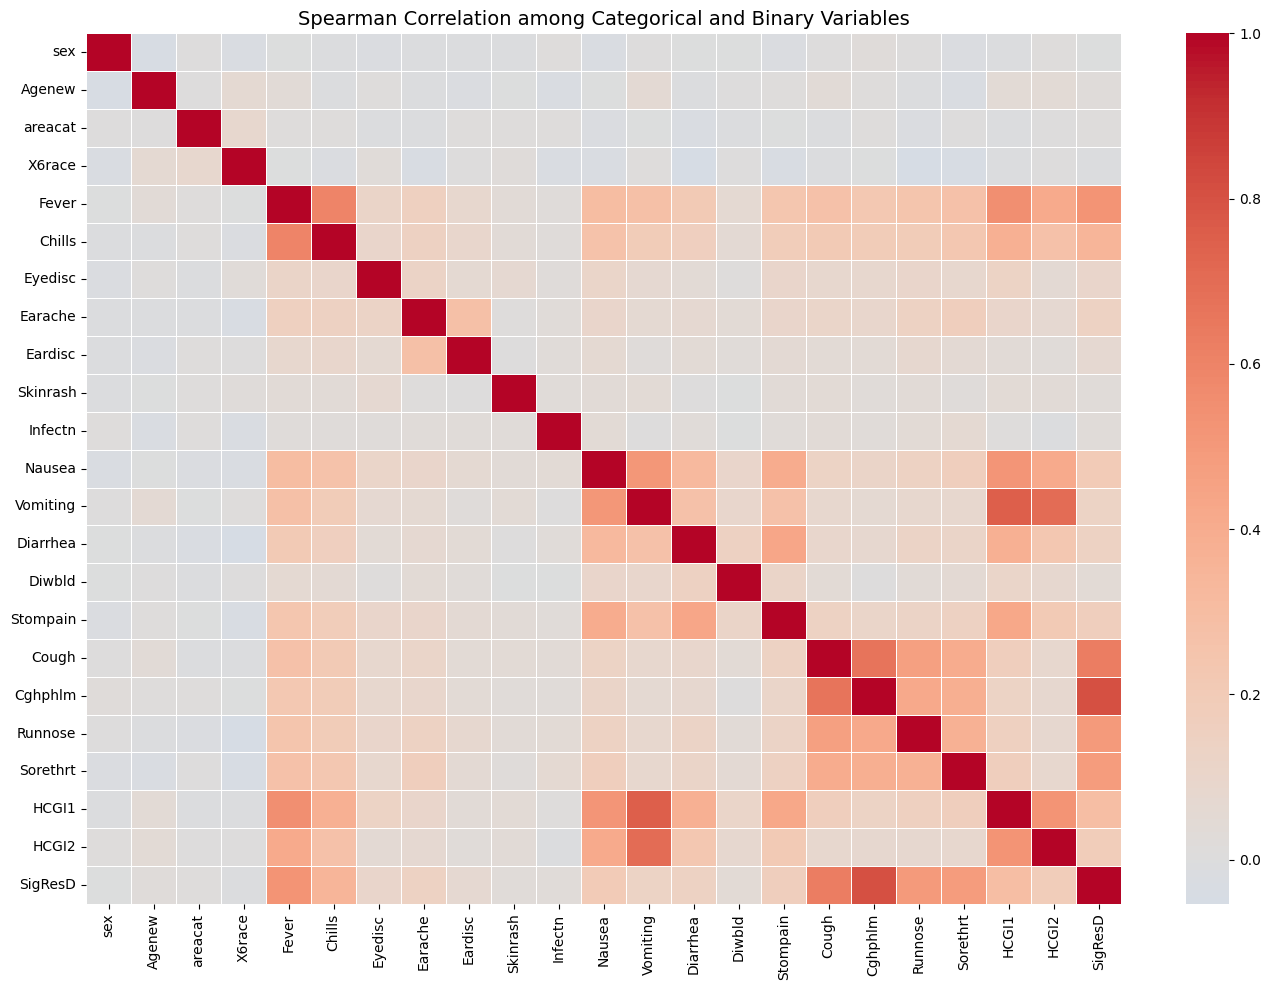

In [16]:

# Select relevant variables 
cat_vars = [
    'sex', 'Agenew', 'areacat', 'X6race',
    'Fever', 'Chills', 'Eyedisc', 'Earache', 'Eardisc', 'Skinrash', 
    'Infectn', 'Nausea', 'Vomiting', 'Diarrhea', 'Diwbld', 'Stompain',
    'Cough', 'Cghphlm', 'Runnose', 'Sorethrt', 'HCGI1', 'HCGI2', 'SigResD'
]

# Compute Spearman correlation
spearman_corr = df[cat_vars].corr(method='spearman')

#  Display numeric correlation matrix
print("Spearman Correlation Matrix (Categorical/Binary Variables):")
display(spearman_corr.round(3))

# Create a heatmap 
plt.figure(figsize=(14, 10))
sns.heatmap(
    spearman_corr, 
    annot=False,        
    cmap='coolwarm', 
    center=0, 
    linewidths=0.5
)
plt.title("Spearman Correlation among Categorical and Binary Variables", fontsize=14)
plt.tight_layout()
plt.show()


In [53]:
# Round table nicely
summary_stats_styled = (
    summary_stats.style
    .set_caption("Table X. Summary of Log-Transformed QG Scores by Distance from Storm Drain")
    .format("{:.3f}")
    .background_gradient(subset=['mean'], cmap='Reds', low=0.2, high=0.8)
)
summary_stats_styled

,count,mean,std,min,25%,50%,75%,max
areacat,,,,,,,,
0,2233.000,0.797,0.103,0.233,0.734,0.791,0.848,1.259
1,2594.000,0.797,0.100,0.314,0.737,0.793,0.846,1.234
2,3466.000,0.794,0.101,0.464,0.732,0.787,0.846,1.270
3,651.000,0.814,0.111,0.498,0.747,0.805,0.856,1.242


#### **Table X** provides numeric summaries, including counts, mean, standard deviation, quartiles, and range for each category. Both the figure and table support the hypothesis that proximity to storm drains may influence gastrointestinal disease severity.

#### Interpretation:

#### Mean & Median QG (Log-transformed)
- The mean QG slightly increases as distance to the drain decreases, with the highest mean in category 3 (0 yds): 0.814 vs ~0.794–0.797 for other categories.
- Median shows a similar trend: swimmers closest to the drain have slightly higher QG.

#### Spread (Std, Min/Max, Quartiles)

- Std deviation is slightly higher in category 3 (0.111), suggesting more variability in disease severity for swimmers nearest the drain.
- Max values are roughly similar across categories, meaning extreme high QG scores exist in all distance groups, but are slightly more pronounced near the drain.

#### Counts
- Most participants are in categories 0–2; category 3 (closest to drain) has the fewest (651). Keep this in mind — smaller group sizes may affect statistical power in regression or comparisons.

#### Overall insight:
- There is a subtle but consistent trend: swimmers closer to the storm drain tend to have slightly higher and more variable gastrointestinal severity scores.
- This aligns with the main exposure hypothesis and may be more informative than individual bacterial indicators, which didn’t correlate well with QG.

#### RESULTS:
When examining log-transformed QG scores by distance from the nearest storm drain (areacat), participants swimming closest to the drain (0 yds, category 3) had slightly higher mean (0.814) and median (0.805) scores compared to those farther away (categories 0–2, mean ~0.794–0.797). Variability in QG scores was also higher for swimmers closest to the drain (Std = 0.111), suggesting greater heterogeneity in gastrointestinal outcomes. These findings support the hypothesis that proximity to storm drains may influence gastrointestinal disease severity.

##### Transition to Regression Modeling

The exploratory analyses indicate that both quantitative severity (log-transformed QG scores) and gastrointestinal outcomes vary modestly with exposure to storm drains. While raw QG scores were highly skewed, the log-transformed scores provide a more symmetric distribution suitable for regression modeling. Additionally, the prevalence patterns of gastrointestinal outcomes suggest potential associations with distance from storm drains, highlighting areacat as a key exposure variable.

Based on these findings, subsequent modeling will focus on:

1. Predicting log-transformed QG scores using microbial indicators (X28fecal_log, ecoli_log, enter_log, totalc_log) and relevant covariates (age, sex, socioeconomic status, beach ID, etc.) with regression models.

2. Classifying participants into gastrointestinal disease categories derived from the QG score or binary GI outcomes, using classification models.

This approach ensures that the models are grounded in the observed EDA patterns and account for both quantitative severity and categorical health outcomes.

### FINAL CODE

Original dataset shape: (11686, 32)
Dataset after removing rows with missing key variables: (8944, 32)

Dataset after all cleaning steps: (8944, 38)
Classification threshold (median QG): 5.180
Class distribution:
QG_cat
Low     4490
High    4454
Name: count, dtype: int64

Checking for remaining missing values:
Regression dataset missing values: 0
Classification dataset missing values: 0

Final dataset sizes:
Regression: (8944, 28)
Classification: (8944, 28)

Train-test split:
  Regression - Train: 6260, Test: 2684
  Classification - Train: 6260, Test: 2684

PART 1: REGRESSION MODELS (Predicting Continuous QG_log)

--- Feature Selection using Lasso ---
Number of features selected by Lasso: 26
Selected features: ['X28fecal_log', 'ecoli_log', 'totalc_log', 'Fever', 'Chills', 'Eyedisc', 'Earache', 'Skinrash', 'Infectn', 'Nausea']...

--- Model 1: Multiple Linear Regression ---
Linear Regression R²: 0.526
Linear Regression RMSE: 0.073
Linear Regression MAE: 0.057

--- Model 2: Random Forest

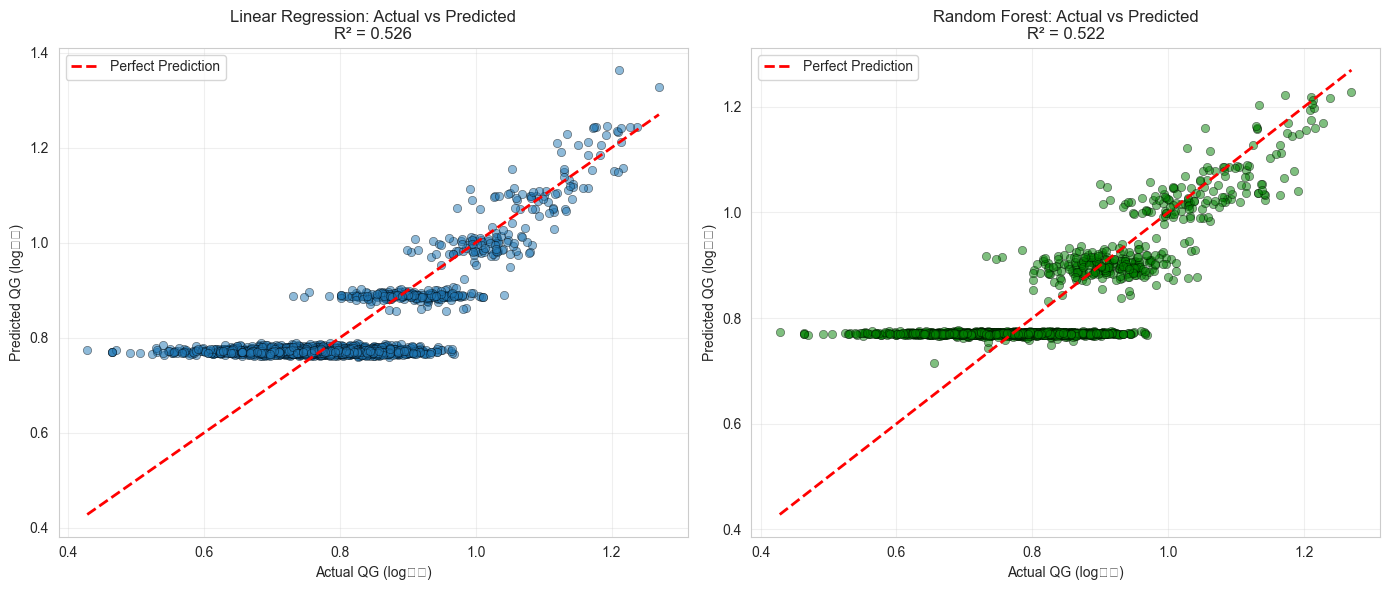

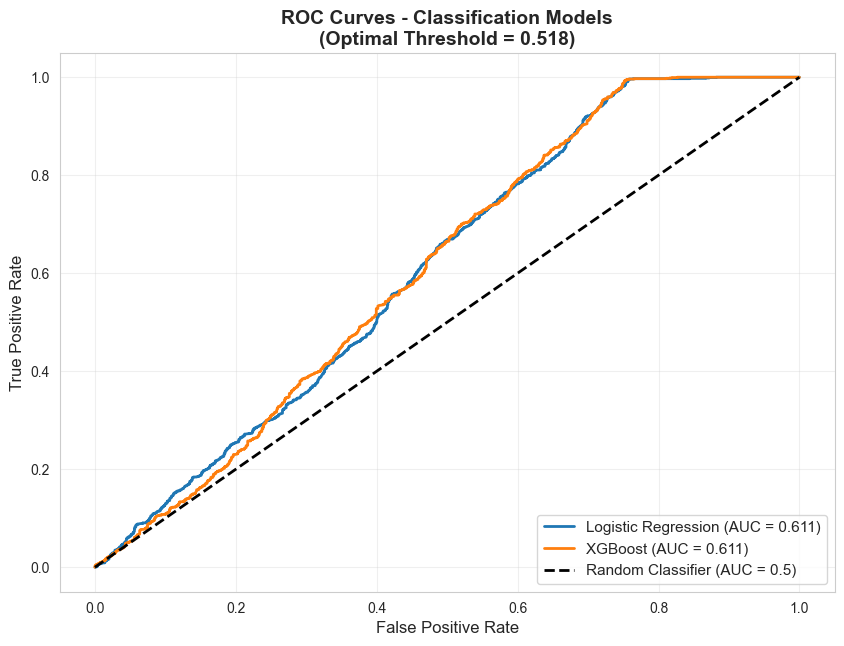

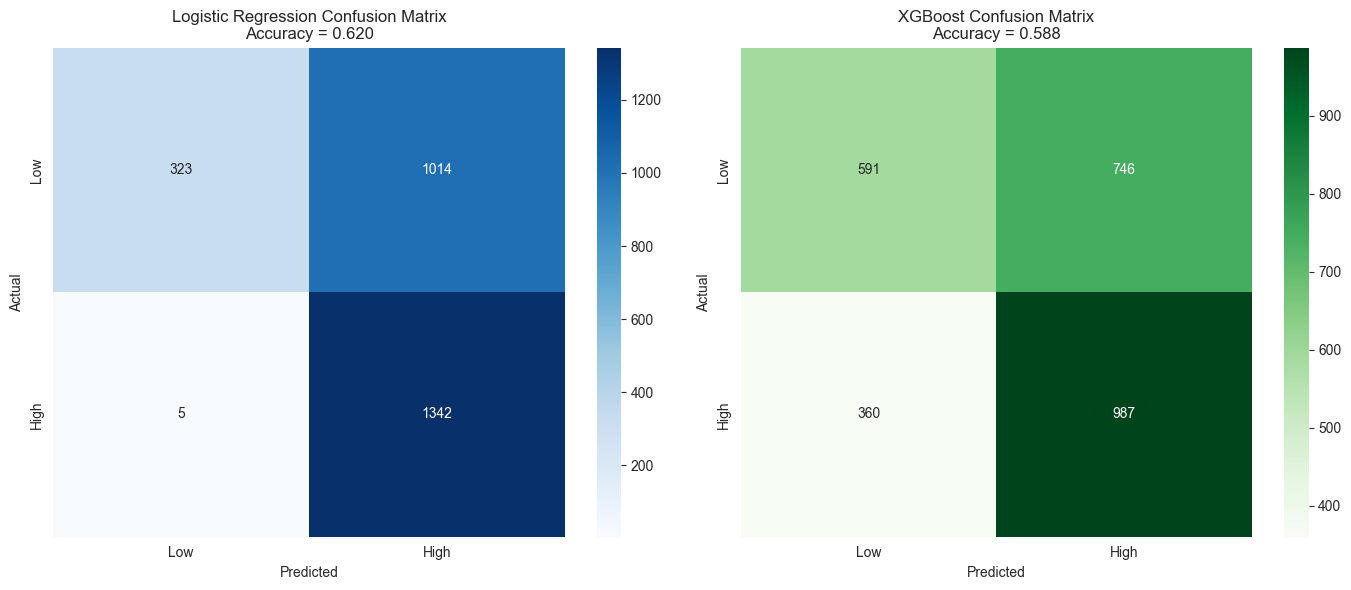

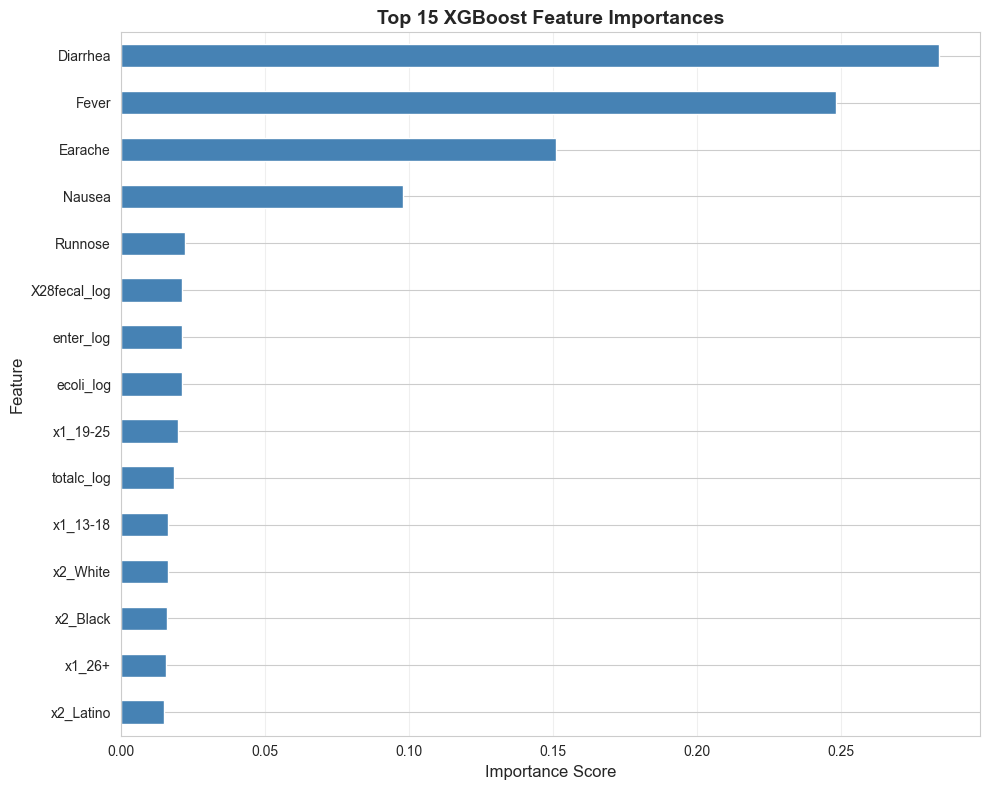

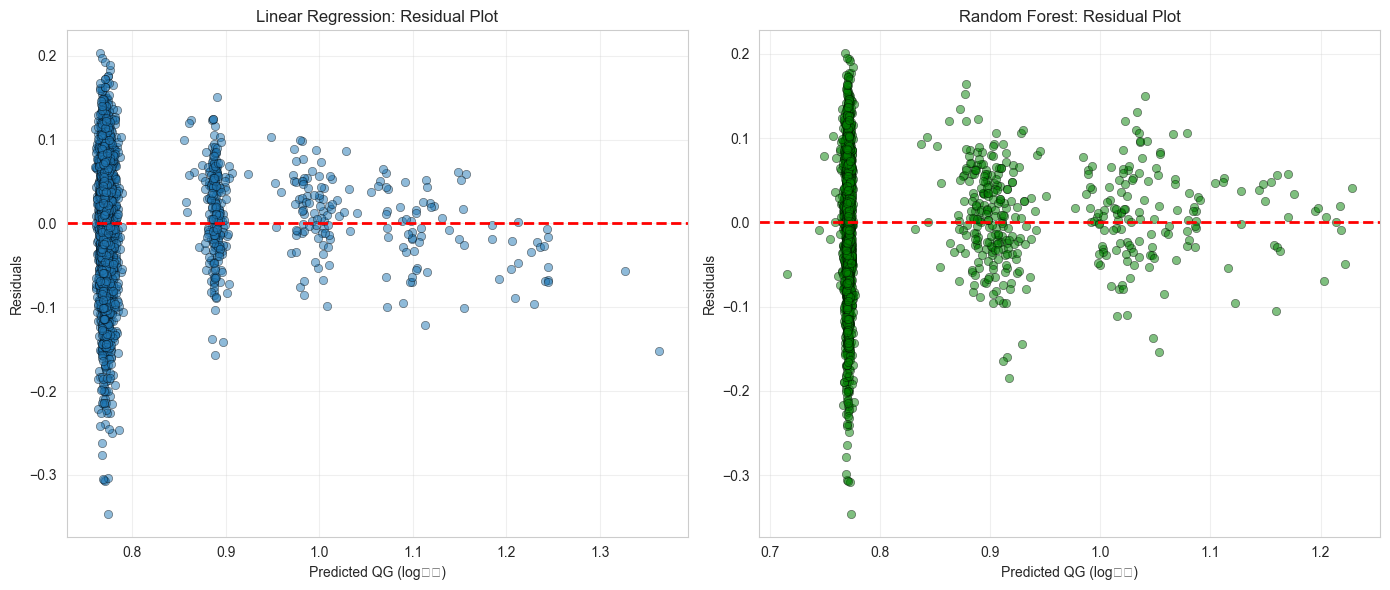


ANALYSIS COMPLETE!
All visualizations saved as PNG files.


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, roc_auc_score,
                             classification_report)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv('santa.csv')
print(f"Original dataset shape: {df.shape}")

# Replace missing values (99999.99 coded as missing)
df = df.replace(99999.99, np.nan)

# Drop rows with missing microbial indicators and SES (as you did in your EDA)
df = df.dropna(subset=['ses', 'X28fecal', 'ecoli', 'enter', 'totalc'])
print(f"Dataset after removing rows with missing key variables: {df.shape}")

# Create log-transformed microbial variables
df['X28fecal_log'] = np.log10(df['X28fecal'] + 1)
df['ecoli_log'] = np.log10(df['ecoli'] + 1)
df['enter_log'] = np.log10(df['enter'] + 1)
df['totalc_log'] = np.log10(df['totalc'] + 1)

# Create log-transformed target for regression
df['QG_log'] = np.log10(df['QG'] + 1)

# ====== Proper Mapping of Numeric Categories to String Labels ======
race_map = {0: 'White', 1: 'Black', 2: 'Latino', 3: 'Asian', 4: 'Multiethnic/Other'}
age_map = {8: '0-12', 7: '13-18', 6: '19-25', 5: '26+'}
areacat_map = {0: '400_yds', 1: '50_100_yds', 2: '1_50_yds', 3: '0_yds'}
sex_map = {0: 'Female', 1: 'Male'}

def safe_map_and_fill(series, mapping):
    s = series.map(mapping).astype('category')
    if 'Unknown' not in s.cat.categories:
        s = s.cat.add_categories('Unknown')
    return s.fillna('Unknown')

df['X6race'] = safe_map_and_fill(df['X6race'], race_map)
df['Agenew'] = safe_map_and_fill(df['Agenew'], age_map)
df['areacat'] = safe_map_and_fill(df['areacat'], areacat_map)
df['sex'] = safe_map_and_fill(df['sex'], sex_map)

# Define variables
target_regress = 'QG_log'
target_class = 'QG_cat'
microbial_vars = ['X28fecal_log', 'ecoli_log', 'enter_log', 'totalc_log']
distance_var = ['areacat']
covariates = [
    'sex', 'Agenew', 'X6race',
    'Fever', 'Chills', 'Eyedisc', 'Earache', 'Eardisc', 'Skinrash',
    'Infectn', 'Nausea', 'Vomiting', 'Diarrhea', 'Diwbld', 'Stompain',
    'Cough', 'Cghphlm', 'Runnose', 'Sorethrt', 'HCGI1', 'HCGI2', 'SigResD'
]
predictors = microbial_vars + distance_var + covariates

# ====== Prepare binary classification target based on median QG ======
# Note: QG should have no missing values after the initial cleaning
threshold = df['QG'].median()
df[target_class] = np.where(df['QG'] <= threshold, 'Low', 'High')
df[target_class] = df[target_class].astype('category')

print(f"\nDataset after all cleaning steps: {df.shape}")
print(f"Classification threshold (median QG): {threshold:.3f}")
print(f"Class distribution:\n{df[target_class].value_counts()}")

# Prepare regression and classification datasets
# Use .copy() to avoid modifying the original and only drop if truly necessary
df_reg = df[predictors + [target_regress]].copy()
df_clf = df[predictors + [target_class]].copy()

print(f"\nChecking for remaining missing values:")
print(f"Regression dataset missing values: {df_reg.isnull().sum().sum()}")
print(f"Classification dataset missing values: {df_clf.isnull().sum().sum()}")

# Only drop NaN if there are actually missing values remaining
if df_reg.isnull().sum().sum() > 0:
    print(f"Dropping {df_reg.isnull().any(axis=1).sum()} rows with missing values in regression dataset")
    df_reg = df_reg.dropna()
    
if df_clf.isnull().sum().sum() > 0:
    print(f"Dropping {df_clf.isnull().any(axis=1).sum()} rows with missing values in classification dataset")
    df_clf = df_clf.dropna()

print(f"\nFinal dataset sizes:")
print(f"Regression: {df_reg.shape}")
print(f"Classification: {df_clf.shape}")

X_reg = df_reg[predictors]
y_reg = df_reg[target_regress]

X_clf = df_clf[predictors]
y_clf = df_clf[target_class]

# Train-test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.3, stratify=y_clf, random_state=42)

print(f"\nTrain-test split:")
print(f"  Regression - Train: {X_reg_train.shape[0]}, Test: {X_reg_test.shape[0]}")
print(f"  Classification - Train: {X_clf_train.shape[0]}, Test: {X_clf_test.shape[0]}")

# Define numeric and categorical features
numeric_features = microbial_vars + [
    'Fever', 'Chills', 'Eyedisc', 'Earache', 'Eardisc', 'Skinrash',
    'Infectn', 'Nausea', 'Vomiting', 'Diarrhea', 'Diwbld', 'Stompain',
    'Cough', 'Cghphlm', 'Runnose', 'Sorethrt', 'HCGI1', 'HCGI2', 'SigResD'
]
categorical_features = ['sex', 'Agenew', 'X6race', 'areacat']

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\n" + "="*80)
print("PART 1: REGRESSION MODELS (Predicting Continuous QG_log)")
print("="*80)

# ====== LASSO FEATURE SELECTION FOR REGRESSION ======
print("\n--- Feature Selection using Lasso ---")
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])
lasso_pipeline.fit(X_reg_train, y_reg_train)

all_feature_names = numeric_features + list(
    lasso_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)
lasso_coefs = lasso_pipeline.named_steps['lasso'].coef_
selected_features_reg = [feat for coef, feat in zip(lasso_coefs, all_feature_names) if np.abs(coef) > 1e-5]

print(f"Number of features selected by Lasso: {len(selected_features_reg)}")
print(f"Selected features: {selected_features_reg[:10]}...")  # Show first 10

def build_reduced_preprocessor(selected_features):
    num_feats = [f for f in selected_features if f in numeric_features]
    cat_feats = [f for f in selected_features if f not in numeric_features]
    mapped_cat_feats = list({feat.split('_')[0] for feat in cat_feats})

    return ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_feats if num_feats else numeric_features[:1]),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), mapped_cat_feats if mapped_cat_feats else categorical_features[:1])
    ])

reduced_preprocessor_reg = build_reduced_preprocessor(selected_features_reg)

X_reg_train_red = reduced_preprocessor_reg.fit_transform(X_reg_train)
X_reg_test_red = reduced_preprocessor_reg.transform(X_reg_test)

# ====== MODEL 1: LINEAR REGRESSION ======
print("\n--- Model 1: Multiple Linear Regression ---")
linreg = LinearRegression()
linreg.fit(X_reg_train_red, y_reg_train)
y_pred_linreg = linreg.predict(X_reg_test_red)

r2_linreg = r2_score(y_reg_test, y_pred_linreg)
rmse_linreg = np.sqrt(mean_squared_error(y_reg_test, y_pred_linreg))
mae_linreg = mean_absolute_error(y_reg_test, y_pred_linreg)

print(f"Linear Regression R²: {r2_linreg:.3f}")
print(f"Linear Regression RMSE: {rmse_linreg:.3f}")
print(f"Linear Regression MAE: {mae_linreg:.3f}")

# ====== MODEL 2: RANDOM FOREST REGRESSOR ======
print("\n--- Model 2: Random Forest Regressor ---")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_reg = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf_reg, rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_rf.fit(X_reg_train_red, y_reg_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_reg_test_red)

r2_rf = r2_score(y_reg_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_reg_test, y_pred_rf))
mae_rf = mean_absolute_error(y_reg_test, y_pred_rf)

print(f"Random Forest best params: {grid_rf.best_params_}")
print(f"Random Forest R²: {r2_rf:.3f}")
print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest MAE: {mae_rf:.3f}")

print("\n" + "="*80)
print("PART 2: CLASSIFICATION MODELS (Predicting High vs Low QG)")
print("="*80)

# ====== FEATURE SELECTION FOR CLASSIFICATION ======
print("\n--- Feature Selection using Random Forest Importance ---")
X_clf_train_full = preprocessor.fit_transform(X_clf_train)
rf_clf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_fs.fit(X_clf_train_full, y_clf_train)

feature_names = numeric_features + list(
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
)
importances_clf = pd.Series(rf_clf_fs.feature_importances_, index=feature_names).sort_values(ascending=False)
top_n_clf = 15
top_features_clf = importances_clf.head(top_n_clf).index.tolist()

print(f"Top {top_n_clf} selected features for classification:")
print(top_features_clf)

reduced_preprocessor_clf = build_reduced_preprocessor(top_features_clf)

X_clf_train_red = reduced_preprocessor_clf.fit_transform(X_clf_train)
X_clf_test_red = reduced_preprocessor_clf.transform(X_clf_test)

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_clf_train_res, y_clf_train_res = sm.fit_resample(X_clf_train_red, y_clf_train)

print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_clf_train_res).value_counts())

# Encode labels
le = LabelEncoder()
y_clf_train_enc = le.fit_transform(y_clf_train_res)
y_clf_test_enc = le.transform(y_clf_test)

# ====== MODEL 1: LOGISTIC REGRESSION WITH STRATIFIED K-FOLD CV ======
print("\n--- Model 1: Logistic Regression (L1 penalty) ---")

# Use Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_logreg = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'max_iter': [1000],
}

logreg = LogisticRegression()
grid_logreg = GridSearchCV(logreg, param_logreg, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
grid_logreg.fit(X_clf_train_res, y_clf_train_enc)

best_logreg = grid_logreg.best_estimator_
print(f"Logistic Regression best params: {grid_logreg.best_params_}")
print(f"Best CV F1 score: {grid_logreg.best_score_:.3f}")

# Get probability predictions
y_pred_proba_lr = best_logreg.predict_proba(X_clf_test_red)[:, 1]

# Find optimal threshold using F1 score
from sklearn.metrics import precision_recall_curve

print("\n--- Finding Optimal Threshold for Logistic Regression ---")
precision, recall, thresholds = precision_recall_curve(y_clf_test_enc, y_pred_proba_lr)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
optimal_idx = np.argmax(f1_scores)
OPTIMAL_THRESHOLD_LR = thresholds[optimal_idx]

print(f"Optimal threshold found: {OPTIMAL_THRESHOLD_LR:.3f}")
print(f"Expected F1 score at optimal threshold: {f1_scores[optimal_idx]:.3f}")

# Apply optimal threshold for Logistic Regression
y_pred_logreg_enc_adjusted = (y_pred_proba_lr >= OPTIMAL_THRESHOLD_LR).astype(int)
y_pred_logreg_adjusted = le.inverse_transform(y_pred_logreg_enc_adjusted)

print(f"\nUsing optimal threshold for Logistic Regression: {OPTIMAL_THRESHOLD_LR:.3f}")

# ====== MODEL 2: XGBOOST WITH STRATIFIED K-FOLD CV ======
print("\n--- Model 2: XGBoost Classifier ---")

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8]
}

grid_xgb = GridSearchCV(xgb_clf, param_xgb, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
grid_xgb.fit(X_clf_train_res, y_clf_train_enc)

best_xgb = grid_xgb.best_estimator_
print(f"XGBoost best params: {grid_xgb.best_params_}")
print(f"Best CV F1 score: {grid_xgb.best_score_:.3f}")

# Get probability predictions for XGBoost
y_pred_proba_xgb = best_xgb.predict_proba(X_clf_test_red)[:, 1]

# Use same optimal threshold for fair comparison
y_pred_xgb_enc_adjusted = (y_pred_proba_xgb >= OPTIMAL_THRESHOLD_LR).astype(int)
y_pred_xgb_adjusted = le.inverse_transform(y_pred_xgb_enc_adjusted)

print(f"\nUsing same threshold for XGBoost: {OPTIMAL_THRESHOLD_LR:.3f}")

# ====== EVALUATION FUNCTION ======
def evaluate_cls(name, y_true, y_pred, y_pred_proba=None):
    print(f"\n{name} Classification Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.3f}")
    print(f"F1 (macro): {f1_score(y_true, y_pred, average='macro'):.3f}")
    if y_pred_proba is not None:
        y_true_enc = le.transform(y_true)
        print(f"ROC-AUC: {roc_auc_score(y_true_enc, y_pred_proba):.3f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return cm

print("\n" + "="*80)
print(f"CLASSIFICATION RESULTS WITH OPTIMAL THRESHOLD ({OPTIMAL_THRESHOLD_LR:.3f})")
print("="*80)

cm_lr = evaluate_cls('Logistic Regression', y_clf_test, y_pred_logreg_adjusted, y_pred_proba_lr)
cm_xgb = evaluate_cls('XGBoost', y_clf_test, y_pred_xgb_adjusted, y_pred_proba_xgb)

# ====== VISUALIZATIONS ======
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Model Performance Comparison Table
print("\n--- Model Performance Summary ---")
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Logistic Regression', 'XGBoost'],
    'Type': ['Regression', 'Regression', 'Classification', 'Classification'],
    'Primary Metric': [f'R²: {r2_linreg:.3f}', f'R²: {r2_rf:.3f}', 
                       f'Accuracy: {accuracy_score(y_clf_test, y_pred_logreg_adjusted):.3f}',
                       f'Accuracy: {accuracy_score(y_clf_test, y_pred_xgb_adjusted):.3f}'],
    'Secondary Metric': [f'RMSE: {rmse_linreg:.3f}', f'RMSE: {rmse_rf:.3f}',
                        f'F1: {f1_score(y_clf_test, y_pred_logreg_adjusted, average="macro"):.3f}',
                        f'F1: {f1_score(y_clf_test, y_pred_xgb_adjusted, average="macro"):.3f}']
})
print(results_df.to_string(index=False))

# 2. Regression: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_reg_test, y_pred_linreg, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_reg_test.min(), y_reg_test.max()], 
             [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual QG (log₁₀)')
axes[0].set_ylabel('Predicted QG (log₁₀)')
axes[0].set_title(f'Linear Regression: Actual vs Predicted\nR² = {r2_linreg:.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_reg_test, y_pred_rf, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[1].plot([y_reg_test.min(), y_reg_test.max()], 
             [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual QG (log₁₀)')
axes[1].set_ylabel('Predicted QG (log₁₀)')
axes[1].set_title(f'Random Forest: Actual vs Predicted\nR² = {r2_rf:.3f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. ROC Curves for Classification Models
fpr_lr, tpr_lr, _ = roc_curve(y_clf_test_enc, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_clf_test_enc, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves - Classification Models\n(Optimal Threshold = {OPTIMAL_THRESHOLD_LR:.3f})', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Confusion Matrices Side by Side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
axes[0].set_title(f'Logistic Regression Confusion Matrix\nAccuracy = {accuracy_score(y_clf_test, y_pred_logreg_adjusted):.3f}')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
axes[1].set_title(f'XGBoost Confusion Matrix\nAccuracy = {accuracy_score(y_clf_test, y_pred_xgb_adjusted):.3f}')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# 5. Feature Importance for XGBoost
# Get the actual categorical features used in reduced_preprocessor_clf
def get_actual_cat_features(top_features_list, all_cat_features):
    """Extract which categorical features are actually used based on one-hot encoded names"""
    used_cats = set()
    for feat in top_features_list:
        for cat in all_cat_features:
            if feat.startswith(cat + '_'):
                used_cats.add(cat)
    return list(used_cats)

actual_cat_features = get_actual_cat_features(top_features_clf, categorical_features)

def get_feature_names_fixed(preproc):
    """Get feature names from the fitted preprocessor"""
    # Get numeric features
    num_feats = [t[2] for t in preproc.transformers_ if t[0] == 'num'][0]
    
    # Get categorical feature names from the fitted encoder
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out()
    
    return list(num_feats) + list(cat_names)

xgb_feature_names = get_feature_names_fixed(reduced_preprocessor_clf)

# Verify dimensions match
if len(xgb_feature_names) != len(best_xgb.feature_importances_):
    print(f"Warning: Feature name count ({len(xgb_feature_names)}) doesn't match importance count ({len(best_xgb.feature_importances_)})")
    # Fallback to generic names
    xgb_feature_names = [f"Feature_{i}" for i in range(len(best_xgb.feature_importances_))]

importances = pd.Series(best_xgb.feature_importances_, index=xgb_feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.tail(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 XGBoost Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 6. Residuals Plot for Regression
residuals_lr = y_reg_test - y_pred_linreg
residuals_rf = y_reg_test - y_pred_rf

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_pred_linreg, residuals_lr, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted QG (log₁₀)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression: Residual Plot')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted QG (log₁₀)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Random Forest: Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

